## [NLP FROM SCRATCH: GENERATING NAMES WITH A CHARACTER-LEVEL RNN](https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html#nlp-from-scratch-generating-names-with-a-character-level-rnn)

#### We are still hand-crafting a small RNN with a few linear layers. The big difference is instead of predicting a category after reading in all the letters of a name, we input a category and output one letter at a time. Recurrently predicting characters to form language (this could also be done with words or other higher order constructs) is often referred to as a “language model”.

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open

In [2]:
import os
from glob import glob

In [3]:
import string
import unicodedata

In [4]:
home = os.environ['HOME']
data_dir = f"{home}/torch/data/"
names_dir = data_dir + "names/"

In [5]:
all_letters = string.ascii_letters +" .,;'-"

In [6]:
n_letters =  len(all_letters) + 1

In [7]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [8]:
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

In [9]:
category_lines = {}
all_categories = []

In [10]:
def findFiles(path): return glob(path)

In [11]:
for filename in findFiles('/home/drclab/torch/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

In [12]:
n_categories = len(all_categories)

_____

To represent a single letter, we use a “one-hot vector” of size <1 x n_letters>. A one-hot vector is filled with 0s except for a 1 at index of the current letter, e.g. "b" = <0 1 0 0 0 ...>.

To make a word we join a bunch of those into a 2D matrix <line_length x 1 x n_letters>.

In [13]:
def letterToIndex(letter):
    return all_letters.find(letter)

In [14]:
import torch

In [15]:
# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

In [16]:
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

#### This network extends the last tutorial’s RNN with an extra argument for the category tensor, which is concatenated along with the others. The category tensor is a one-hot vector just like the letter input.

We will interpret the output as the probability of the next letter. When sampling, the most likely output letter is used as the next input letter.

I added a second linear layer o2o (after combining hidden and output) to give it more muscle to work with. There’s also a dropout layer, which randomly zeros parts of its input with a given probability (here 0.1) and is usually used to fuzz inputs to prevent overfitting. Here we’re using it towards the end of the network to purposely add some chaos and increase sampling variety.

![rnn](https://i.imgur.com/jzVrf7f.png)

In [17]:
import torch
import torch.nn as nn

In [18]:
class RNN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super(RNN, self).__init__()
        self.hidden_size =hidden_dim

        self.i2h = nn.Linear(n_categories + in_dim + hidden_dim, hidden_dim)
        self.i2o = nn.Linear(n_categories + in_dim + hidden_dim, out_dim)
        self.o2o = nn.Linear(hidden_dim + out_dim, out_dim)
        self.dropout = nn.Dropout(p=0.1)
        self.softmax = nn.LogSoftmax(dim=1)
 
    def forward(self, category,input, hidden):
        #print(category.size(), input.size(), hidden.size())
        input_combo = torch.cat((category, input, hidden), dim=1)
        hidden = self.i2h(input_combo)
        out = self.i2o(input_combo)
        out_combo = torch.cat((hidden, out), 1)
        output = self.o2o(out_combo)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def init_Hidden(self):
        return torch.zeros(1, self.hidden_size)

In [19]:
import random

In [20]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

In [21]:
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

![](https://i.imgur.com/JH58tXY.png)

##### The category tensor is a one-hot tensor of size <1 x n_categories>. When training we feed it to the network at every timestep - this is a design choice, it could have been included as part of initial hidden state or some other strategy.

In [22]:
def category2Tensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

In [23]:
def name2Tensor(name):
    tensor = torch.zeros(len(name), 1, n_letters)
    for li in range(len(name)):
        letter = name[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

In [24]:
def target2Tensor(name):
    letter_indices = [all_letters.find(name[li]) for li in range(1, len(name))]
    letter_indices.append(n_letters-1)
    return torch.LongTensor(letter_indices)


##### In contrast to classification, where only the **last output** is used, we are making a prediction at every step, so we are calculating loss at every step. The magic of **autograd** allows you to simply sum these losses at each step and call backward at the end.

In [25]:
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = category2Tensor(category)
    input_line_tensor = name2Tensor(line)
    target_line_tensor = target2Tensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

In [26]:
criterion = nn.NLLLoss()
learning_rate = 0.0005

In [27]:
def train(model, ceten, nameten, tgten):
    tgten.unsqueeze_(-1)
    hidden = model.init_Hidden()

    model.zero_grad()

    loss = 0

    for i in range(nameten.size(0)):
        output, hidden = model(ceten, nameten[i], hidden)
        l = criterion(output, tgten[i])
        loss += l

    loss.backward()

    for p in model.parameters():
        p.data.add_(p.grad.data, alpha = -learning_rate)

    return output, loss.item() / nameten.size(0)

In [28]:
rnn = RNN(n_letters, 128, n_letters)

### [Training RNN](https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html#training-the-network)

In [30]:
import time
import math

In [31]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m,s)

In [39]:
n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []

total_loss = 0 # Reset every plot_every iters

In [40]:
start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(rnn, *randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 23s (5000 5%) 1.4484
0m 46s (10000 10%) 1.9360
1m 10s (15000 15%) 1.2487
1m 34s (20000 20%) 2.1857
1m 57s (25000 25%) 3.1235
2m 21s (30000 30%) 1.8314
2m 45s (35000 35%) 2.9499
3m 10s (40000 40%) 2.4189
3m 33s (45000 45%) 2.7009
3m 56s (50000 50%) 2.6816
4m 20s (55000 55%) 2.7252
4m 44s (60000 60%) 2.1489
5m 3s (65000 65%) 3.1081
5m 23s (70000 70%) 2.8725
5m 43s (75000 75%) 2.5261
6m 6s (80000 80%) 2.5561
6m 25s (85000 85%) 1.7309
6m 44s (90000 90%) 1.8926
7m 4s (95000 95%) 1.8067
7m 28s (100000 100%) 2.6379


In [41]:
import matplotlib.pyplot as plt

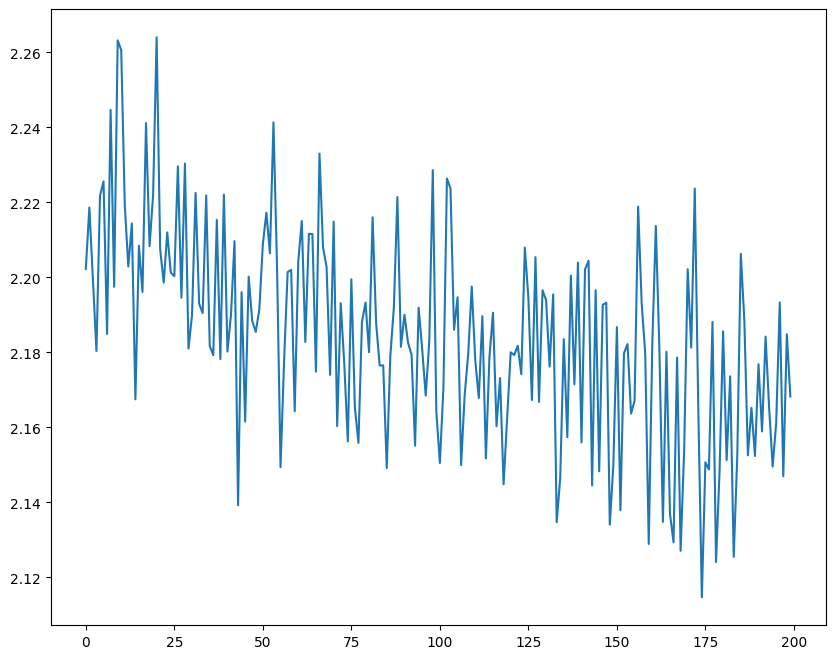

In [43]:
plt.figure(figsize=(10,8))
plt.plot(all_losses)

### [Sampling the Network](https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html#sampling-the-network)

##### To sample we give the network a letter and ask what the next one is, feed that in as the next letter, and repeat until the EOS token.

Create tensors for input category, starting letter, and empty hidden state

Create a string output_name with the starting letter

Up to a maximum output length,

Feed the current letter to the network

Get the next letter from highest output, and next hidden state

If the letter is EOS, stop here

If a regular letter, add to output_name and continue

Return the final name

In [44]:
max_length = 20

In [49]:
def sample(category, start_letter = 'A'):
    catensor = category2Tensor(category)
    input = name2Tensor(start_letter)
    hidden = rnn.init_Hidden()

    outname = start_letter

    for i in range(max_length):
        output, hidden = rnn(catensor, input[0], hidden)
        topv, topi = output.topk(1)
        topi = topi[0][0]
        if topi == n_letters -1:
            break
        else:
            letter = all_letters[topi]
            outname += letter
    
        input = name2Tensor(letter)

    return outname
        


In [52]:
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

In [53]:
samples("Russian", 'RUS')

Romandev
Uriskov
Shimatev
